In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime
from faker import Faker

**Steps:**
1. [x] Decide the variables 
2. [ ] Fake data for one student 
3. [ ] Fake data for one class
4. [ ] Fake data for multiple classes 
5. [ ] Fake data for multiple terms 

---
### Decide the variables:

In [2]:
# Basic_Info:
    # id 
    # f_name
    # l_name
    # gender
    # race
    # birth_dt
    # address
    # email
    
# Academic_Performance:
    # Grades of quizzes, tests, home assignments
    # Attendance
    # Number of on-time, late, and missed assignments
    # Number of accesses to LMS
    # Average time spent on LMS
    # Messages on LMS (for example, number of questions and responses on the discussion forum)

---
### Fake data for one student:

In [375]:
import bisect

def bi_search(arr, x): # binary search
    i = bisect.bisect(arr, x)-1
    if i != len(arr) and arr[i] == x:
        return i
    return False

bi_search(np.asarray([1, 2, 5, 8]), 6)

False

In [376]:
def ewma_predict(series, span=3, jump=1): # jump is the diff in time bw the date of prediction & the last observation
    if len(series) == 1: #if the series has only 1 element
        return series.iloc[0]
    
    inter = series.ewm(span=span).mean().iloc[-1]
    
    differences = series.diff()
    slope = differences.ewm(span=span).mean().iloc[-1]
    
    return inter + slope*jump

In [377]:
def fake_student_grades(grade1_mu, grade1_std, n_tests, n_home, last_home_pos, n_exams, exam1_pos):
    total_n_grades = n_home + n_tests + n_exams 
    # total number of grades: home assignments, tests, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_pos, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_pos, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_tests-1
    
    for i, pos in enumerate(home_pos):
        if bi_search(exam_pos, pos): # check if the positions of home assignments and exams overlap 
            home_pos[i] -= 1         # if so, subtract the position of the home assignment by 1
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    test_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the tests
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    print("Variation std:", var_std)
    
    for t in range(total_n_grades-1):
        span = 3
        if bi_search(home_pos, t): # the grades of home assignments tend to be higher: mu=1
            variation = random.gauss(1, var_std) 
        elif bi_search(exam_pos, t): # the grades of exams tend to be lower: mu=-1
            variation = random.gauss(-1, var_std)
            span = 5 # exams tend to cover a larger range of content
        else: 
            variation = random.gauss(0, var_std)
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    test_series = grade_series.iloc[test_pos]
        
    return grade_series, home_series, exam_series, test_series

# n_tests = 7
# n_home = 10
# n_last_home = 18 
# n_exams = 3
# exam1_pos = 4

fake_student_grades(78, 7, 7, 10, 18, 3, 4)
# what about missed home assignment?

Variation std: 2.961040521724093


(0    74.0
 0    76.0
 0    77.0
 0    76.0
 0    72.0
 0    74.0
 0    77.0
 0    76.0
 0    83.0
 0    79.0
 0    75.0
 0    80.0
 0    77.0
 0    78.0
 0    77.0
 0    78.0
 0    76.0
 0    71.0
 0    73.0
 0    77.0
 dtype: float64,
 0    74.0
 0    77.0
 0    72.0
 0    77.0
 0    83.0
 0    75.0
 0    80.0
 0    77.0
 0    76.0
 0    73.0
 dtype: float64,
 0    72.0
 0    77.0
 0    77.0
 dtype: float64,
 0    76.0
 0    76.0
 0    74.0
 0    76.0
 0    79.0
 0    78.0
 0    78.0
 0    71.0
 dtype: float64)

In [456]:
def miss_chance(index, cum_mean_grade, gra_slope=0.5):
    if index < 2: # first few assignments
        return random.betavariate(1, 19)*100 # very unlikely to miss on the first few assignments
    
    if cum_mean_grade >= 70: # C- or higher
        missed = random.betavariate(1, 15)*100 - gra_slope*np.power(cum_mean_grade, 0.73)
    else:
        missed = random.betavariate(2, 10)*100 - (gra_slope-0.1)*np.power(cum_mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 70
    
    return missed

miss_chance(1, 60)

0.60284399686748

In [465]:
def fake_student_grades(grade1_mu, grade1_std, n_tests, n_home, last_home_pos, n_exams, exam1_pos):
    total_n_grades = n_home + n_tests + n_exams 
    # total number of grades: home assignments, tests, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_pos, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_pos, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_tests-1
    
    for i, pos in enumerate(home_pos):
        if bi_search(exam_pos, pos): # check if the positions of home assignments and exams overlap 
            home_pos[i] -= 1         # if so, subtract the position of the home assignment by 1
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    test_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the tests
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade1 = grade1 if grade1 >= 0 else 0 # can't be < 0
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    print("Variation std:", var_std)
    
    for t in range(total_n_grades-1):
        span = 3
        if bi_search(home_pos, t): # the grades of home assignments tend to be higher: mu=1
            index = bi_search(home_pos, t)
            cum_mean_grade = grade_series.mean()
            
            if miss_chance(index, cum_mean_grade)>30:
                grade_series = grade_series.append(pd.Series(0)) # missed if miss_chance > 40%
                continue
            variation = random.gauss(1, var_std)
        
        elif bi_search(exam_pos, t): # the grades of exams tend to be lower: mu=-1
            variation = random.gauss(-1, var_std)
            span = 5 # exams tend to cover a larger range of content
        else: 
            variation = random.gauss(0, var_std)
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = next_grade if next_grade >= 0 else 0 # can't be < 0
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    test_series = grade_series.iloc[test_pos]
        
    return grade_series, home_series, exam_series, test_series

# n_tests = 7
# n_home = 10
# n_last_home = 18 
# n_exams = 3
# exam1_pos = 4

# fake_student_grades(78, 7, 7, 10, 18, 3, 4)

# what about the grades of missed home assignments?

##################################################

def fake_student_submission(mean_grade, home_grade_series, ontime_slope=0.3):
    missed = home_grade_series.loc[home_grade_series==0].count()
    missed = missed*100/len(home_grade_series)
    missed = float('{:.2f}'.format(missed)) # round to 2 decimal places
    
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = float('{:.2f}'.format(on_time))
    
    late = 100 - on_time - missed
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed

#fake_student_submission(60, pd.Series([65, 60, 0, 55, 67]))
fake_student_grades(60, 7, 7, 10, 18, 3, 4)

Variation std: 2.1015963763113543


(0    58.0
 0    53.0
 0    49.0
 0    48.0
 0    52.0
 0    55.0
 0    56.0
 0    57.0
 0    59.0
 0    61.0
 0    61.0
 0    62.0
 0     0.0
 0    16.0
 0    16.0
 0    19.0
 0    19.0
 0    23.0
 0    26.0
 0    28.0
 dtype: float64,
 0    58.0
 0    49.0
 0    52.0
 0    56.0
 0    59.0
 0    61.0
 0    62.0
 0    16.0
 0    19.0
 0    26.0
 dtype: float64,
 0    52.0
 0     0.0
 0    28.0
 dtype: float64,
 0    53.0
 0    48.0
 0    55.0
 0    57.0
 0    61.0
 0    16.0
 0    19.0
 0    23.0
 dtype: float64)

In [358]:
def fake_student_attendance(mean_grade, min_gra_slope=0.4, max_gra_slope=0.6, hi_beta_para=(13, 2), lo_beta_para=(30, 25)):
    # slope is from a uniform distribution
    slope = random.uniform(min_gra_slope, max_gra_slope)
    # print('slope:', slope)

    # intercept is from a beta distribution
    if mean_grade >= 70: # C- or higher
        inter = random.betavariate(hi_beta_para[0], hi_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.7)*slope + inter
    else:
        inter = random.betavariate(lo_beta_para[0], lo_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.6)*slope + inter
    # print('Inter:', inter)
     
    attendance = attendance if attendance<100 else 100 # cannot be > 100
    attendance = float('{:.2f}'.format(attendance))    # round to 2 decimal places
    
    return attendance

print(fake_student_attendance(90))
print(fake_student_attendance(60))

98.0
61.9


In [481]:
def fake_student_submission(mean_grade, ontime_slope=0.3):
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = float('{:.2f}'.format(on_time))
    
    missed_and_late = 100 - on_time
    
    if mean_grade >= 70: # C- or higher
        missed = random.betavariate(0.5, 9.5)*100 - (ontime_slope+0.2)*np.power(mean_grade, 0.73)
    else:
        missed = random.betavariate(2, 10)*100 - (ontime_slope+0.1)*np.power(mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 60
    
    missed = (missed_and_late*missed)/100
    missed = missed if missed>1 else 0 # if less than 1, consider that as 0
    missed = float('{:.2f}'.format(missed))
    
    late = 100 - on_time - missed
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed
    
print(fake_student_submission(90))
print(fake_student_submission(60))

(91.57, 8.43, 0.0)
(76.07, 21.08, 2.85)


In [378]:
def fake_student_LMS_accesses(mean_grade, gra_slope_mu=1, gra_slope_std=0.1, inter_mu=3, inter_std=0.1): 
    # weekly LMS accesses
    gra_slope = random.gauss(gra_slope_mu, gra_slope_std)
    inter = random.gauss(inter_mu, inter_std) # account for other random factors than grade
    
    weekly_accesses = gra_slope*(mean_grade/10) - inter
    weekly_accesses = weekly_accesses if weekly_accesses > 0 else 0
    weekly_accesses = float('{:.2f}'.format(weekly_accesses))
    
    return weekly_accesses

print(fake_student_LMS_accesses(90))
print(fake_student_LMS_accesses(60))

7.26
3.57


(array([2., 2., 2., 5., 3., 7., 4., 1., 1., 3.]),
 array([59. , 62.2, 65.4, 68.6, 71.8, 75. , 78.2, 81.4, 84.6, 87.8, 91. ]),
 <a list of 10 Patch objects>)

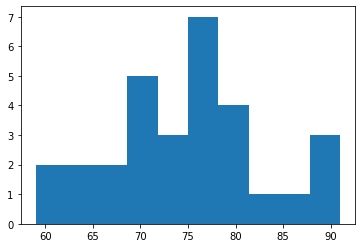

In [157]:
class_size = 30
quiz1_grades = [] 

for i in range(class_size):
    quiz1_grades.append(int(round(random.gauss(mu=75, sigma=10))))
    
plt.hist(quiz1_grades)

In [385]:
s = pd.Series([0, 2, 3])
s.loc[s>1].count()/len(s)

0.6666666666666666

---
### Fake data for one class:

In [9]:
# assume there's no relationship bw basic info & academic performance
def fake_class_basic_info(class_size):
    columns = ['id', 'f_name', 'l_name', 'gender', 'race', 'birth_dt', 'address', 'email']
    info_df = pd.DataFrame(columns=columns)
    
    possible_races = ['White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Mixed']
    race_prob = [0.763, 0.134, 0.013, 0.059, 0.002, 0.029]
    
    # Faker.seed(1234) # for producing the same results 
    fake = Faker()
    
    for s in range(class_size):
        student = {
            'id': fake.ssn(),
            'l_name': fake.last_name(),
            'gender': random.choice(['M', 'F']),
            'race': np.random.choice(possible_races, replace=True, p=race_prob),
            'birth_dt': fake.date_between_dates(date_start=datetime(1997, 1, 1), 
                                                date_end=datetime(2001, 12, 31)),
            'address': fake.address(),
            'email': fake.free_email()
        }    
        student['f_name'] = fake.first_name_male() if student['gender']=='M' else fake.first_name_female()
        
        info_df = info_df.append(student, ignore_index=True)
    
    return info_df

fake_class_basic_info(30)

,id,f_name,l_name,gender,race,birth_dt,address,email
0,389-43-2513,Shawn,Jackson,M,Black,2000-01-17,"07496 Klein Plains\nSouth Davidborough, KS 50447",emily92@yahoo.com
1,367-79-7264,Heather,Jones,F,White,2000-06-28,"PSC 4688, Box 0798\nAPO AA 33332",jennifer55@yahoo.com
2,113-61-7136,Nicole,Quinn,F,White,2001-06-06,"26753 Eric Mall Apt. 778\nWalterfurt, RI 37271",misty16@gmail.com
3,594-82-9097,Shaun,Harrison,M,White,2001-01-24,"10783 Anthony Center Apt. 800\nPort James, DE ...",salazarrichard@hotmail.com
4,720-67-2194,Ronald,Wells,M,White,1999-08-16,"711 Reynolds Wall\nNew Thomasville, VA 26927",crystal62@hotmail.com
5,423-79-5953,Sean,Hill,M,White,2001-03-02,50253 Nicholas Parkways Apt. 365\nLake Lindaha...,blakeroger@yahoo.com
6,547-47-8315,Andrew,Solis,M,White,1999-02-20,"220 Derrick Isle\nLindseyborough, AL 82754",qking@hotmail.com
7,483-63-3232,Jason,Price,M,White,2001-06-05,"747 James Estate Suite 819\nWest Robert, MS 09556",julie67@hotmail.com
8,807-37-6471,Alexa,Jones,F,White,2000-02-06,Unit 9257 Box 6770\nDPO AP 48405,travislopez@gmail.com
9,343-04-2061,Shari,Rangel,F,Mixed,1997-03-01,"22213 Bullock Valley Suite 891\nTylerside, ND ...",hernandezrichard@hotmail.com


In [370]:
def fake_class_performance():
    print()